In [32]:
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
palette1 = "#007BFF"
palette2 = "#3ABFC2"
palette3 = "#E1C081"
palette4 = "#E17A57"
palette5 = "#D92D3F"

model_performance_csv = "replication/computer_vision_output_treatments.csv"
experiment_pilot = "replication/pilot.csv"
pilot_treat = "replication/pilot_treat.csv"
pilot_emo = "replication/pilot_emo.csv"
experiment1_prolific_csv = "replication/e1_prolific.csv"
experiment1_internet_csv = "replication/e1_internet.csv"

# Pilot Experiment

In [33]:
df = pd.read_csv(experiment_pilot)
treat = pd.read_csv(pilot_treat)
emotion = pd.read_csv(pilot_emo)
print("Unique participants: {}".format(df.user_id.nunique()))
print("Guesses: {}".format(df.shape[0]))
temp = pd.DataFrame(df.groupby("user_id").seen.max()).reset_index()
temp.columns = ["user_id","max_seen"]
temp
df = pd.merge(df,temp,on="user_id")
df
print(df.groupby("user_id").max_seen.mean().mean())
print(df.groupby("user_id").max_seen.mean().quantile(.9))
df=df.sort_values(["user_id","time_created"], ascending=True)
df['t2']=pd.to_datetime(df.groupby(['user_id'])['time_created'].shift(1))
df['time_created']=pd.to_datetime(df['time_created'])
# df=df[df.t2.notnull()]
df["delta"]=df.time_created-df.t2
df.delta = df.delta.dt.seconds
df[df.delta<120].delta.describe()
df = df[(df.delta<300) | (df.delta.isnull())]
df = df[(df.delta>10) | (df.delta.isnull())]
n=10
w = pd.merge(treat,df,on="user_id")
w['date'] = pd.to_datetime(w.time_created_y)
gf = w.groupby('user_id')['date'].rank(ascending=True)
w["rank2"] = gf
gf2 = pd.DataFrame(w.groupby("user_id").rank2.max()).reset_index()
gf2.columns = ['user_id','maxrank']
w = pd.merge(w,gf2,on="user_id")
w[w.maxrank>=n].groupby("treatment_one").user_id.nunique()
w2 = w[(w.maxrank>=n)]
t1 = pd.DataFrame(w2.groupby(["rank2",'treatment_one']).correct.agg(["mean","count"])).reset_index()
t2 = pd.DataFrame(w2.groupby(["rank2",'treatment_two']).correct.agg(["mean","count"])).reset_index()
t3 = pd.DataFrame(w2.groupby(["rank2",'treatment_three']).correct.agg(["mean","count"])).reset_index()

print("Mean Accuracy (All Guesses): {}".format(w2[(w2.seen<3) | 
                                                               ((w2.seen<8) & (w2.seen>=5)) |
                                                               (w2.seen==9) |
                                                              (w2.seen==3) & (w2.treatment_two=='4') |
                                                              (w2.seen==4) & (w2.treatment_two=='3') ].groupby("user_id").correct.mean().mean()))

w2["real_one"] = [int("real" in i) for i in w2.imageone]
w2.loc[w2.real_one == 1, 'real'] = w2["imageone"]
w2.loc[w2.real_one == 0, 'real'] = w2["imagetwo"]

w2["fake_one"] = [int("fake" in i) for i in w2.imageone]
w2.loc[w2.real_one == 0, 'fake'] = w2["imageone"]
w2.loc[w2.real_one == 1, 'fake'] = w2["imagetwo"]
# dd = pd.get_dummies(w2.real)
w2['upsidedown'] = 0
w2.loc[(w2.treatment_two=='4') & (w2.seen==4), 'upsidedown'] = 1
w2.loc[(w2.treatment_two=='3') & (w2.seen==3), 'upsidedown'] = 1
w2.loc[(w2.seen==8), 'upsidedown'] = 1
x = pd.DataFrame(w2[["real","fake","correct"]].fake.value_counts().head(56)).reset_index()
x.columns = ["fake","count"]
test = pd.merge(w2[["real","fake","correct"]],x,on="fake")
x = pd.DataFrame(test.groupby("real").correct.mean()).reset_index()
print(sum(x.correct<.5))
print(sum(x.correct<.65))
print(sum(x.correct<.83))

Unique participants: 5524
Guesses: 26820
3.8472121650977553
10.0
Mean Accuracy (All Guesses): 0.7992900334737031
3
12
28


In [34]:
w2["delta"].describe()

count    10674.000000
mean        52.858722
std         39.541800
min         11.000000
25%         27.000000
50%         42.000000
75%         65.000000
max        299.000000
Name: delta, dtype: float64

In [35]:
w2 = w2[w2.seen>0]
res1 = sm.OLS(w2['correct'], sm.add_constant(w2[['seen',"upsidedown", "delta", "treatment_three"]]), M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': w2.real})
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     19.66
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           8.76e-16
Time:                        15:35:56   Log-Likelihood:                -5685.2
No. Observations:               10673   AIC:                         1.138e+04
Df Residuals:                   10668   BIC:                         1.142e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8479      0.018     47.703      0.000       0.813       0.883
seen               -0.0007      0.000     -1.591      0.112      -0.002       0.000
upsidedown         -0.0566      0.020     -2.853      0.004      -0.095      -0.018
delta              -0.0011      0.000     -8.296      0.000      -0.001      -0.001
treatment_three     0.0044      0.008      0.537      0.592      -0.012       0.020
==============================================================================
Omnibus:                     1894.647   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3109.061
Skew:                          -1.319   Prob(JB):                         0.00
Kurtosis:                       2.824   Cond. No.                         246.
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [36]:
w3 = pd.merge(w2,pd.get_dummies(w2.treatment_one), left_index=True,right_index=True)
res1 = sm.OLS(w3['correct'], sm.add_constant(w3[['upsidedown',"happy","anger","anxiety"]]), M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': w3.user_id})
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.829
Date:                Fri, 29 Jan 2021   Prob (F-statistic):            0.00430
Time:                        15:35:56   Log-Likelihood:                -5746.8
No. Observations:               10673   AIC:                         1.150e+04
Df Residuals:                   10668   BIC:                         1.154e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7866      0.007    106.185      0.000       0.772       0.801
upsidedown    -0.0562      0.015     -3.636      0.000      -0.086      -0.026
happy          0.0022      0.013      0.168      0.867      -0.024       0.028
anger         -0.0265      0.021     -1.257      0.209      -0.068       0.015
anxiety       -0.0084      0.014     -0.582      0.560      -0.036       0.020
==============================================================================
Omnibus:                     1940.851   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3217.470
Skew:                          -1.342   Prob(JB):                         0.00
Kurtosis:                       2.810   Cond. No.                         4.10
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [37]:
w4 = pd.merge(w3,emotion,on="user_id")
w4 = w4[["user_id","guess_y",'anger', 'anxiety', 'control_anger',
       'control_anxiety', 'control_happy', 'control_sad', 'happy', "treatment_one"]].drop_duplicates()

In [38]:
w4.guess_y
print("p-value of t-test: {}".format(ttest_ind(*w4[(w4.treatment_one=="anger") | (w4.treatment_one=="control_anger")].groupby('anger')['guess_y'].apply(lambda x:list(x)))[1]))
print("p-value of t-test: {}".format(ttest_ind(*w4[(w4.treatment_one=="anxiety") | (w4.treatment_one=="control_anxiety")].groupby('anxiety')['guess_y'].apply(lambda x:list(x)))[1]))
print("p-value of t-test: {}".format(ttest_ind(*w4[(w4.treatment_one=="happy") | (w4.treatment_one=="control_happy")].groupby('happy')['guess_y'].apply(lambda x:list(x)))[1]))


p-value of t-test: 0.0906701307625482
p-value of t-test: 0.5577544604965696
p-value of t-test: 0.19045333201114656


# Experiment 1

## Prolific

In [39]:
df2 = pd.read_csv(experiment1_prolific_csv)
df2_x = pd.read_csv(experiment1_internet_csv)

In [40]:
sample1 = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]
sample2 = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]
sample1_fake = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==1)]
sample2_fake = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==1)]
sample1_real = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==0)]
sample2_real = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==0)]

print(sample1.human_correct_guess.mean())
print(sample2.human_correct_guess.mean())
print(sample1.computer_correct_guess.mean())
print(sample1_fake.human_correct_guess.mean())
print(sample2_fake.human_correct_guess.mean())
print(sample1_fake.computer_correct_guess.mean())
print(sample1_real.human_correct_guess.mean())
print(sample2_real.human_correct_guess.mean())
print(sample1_real.computer_correct_guess.mean())

0.6639871382636656
0.727710843373494
0.8006430868167203
0.5666666666666667
0.6821963394342762
0.8566666666666667
0.7546583850931677
0.7701863354037267
0.7484472049689441


In [41]:
temp=pd.DataFrame(df2[(df2.guess_round==1) &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)].groupby("prolific_pid")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for DFDC videos".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))
temp=pd.DataFrame(df2[(df2.guess_round==1) &
     (df2.assignment=="control") & ((df2.video=="Putin_10s_b.mp4") | (df2.video=="Putin_10s_a.mp4") 
    | (df2.video=="Kim_10s_b.mp4") | (df2.video=="Kim_10s_a.mp4")) & (df2.pass_check_binary==1)].groupby("prolific_pid")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))

13.100436681222707% humans outperform the computer for DFDC videos
60.0% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin


In [42]:
print((df2[(df2.assignment!="attention_check") & (df2.guess_round==1) & (df2.pass_check_binary==1) &
          (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
            & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4")].guess_int>50).value_counts())
print((df2[(df2.assignment!="attention_check") & (df2.guess_round==1) & (df2.pass_check_binary==1) &
          (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
            & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4")].guess_int<50).value_counts())
print((df2[(df2.assignment!="attention_check") & (df2.guess_round==1) & (df2.pass_check_binary==1) &
          (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
            & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4")].guess_int==50).value_counts())

print(180/(180+2349+1707))
print(2349/(180+2349+1707))
print(1707/(180+2349+1707))

print((df2[(df2.assignment!="attention_check") & (df2.guess_round==1) & (df2.pass_check_binary==1) &
          (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
            & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4")].p>.50).value_counts())
print((df2[(df2.assignment!="attention_check") & (df2.guess_round==1) & (df2.pass_check_binary==1) &
          (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
            & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4")].p<.50).value_counts())
print((df2[(df2.assignment!="attention_check") & (df2.guess_round==1) & (df2.pass_check_binary==1) &
          (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
            & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4")].p==.50).value_counts())
print(612/(612+1753+1871))
print(1753/(612+1753+1871))
print(1871/(612+1753+1871))

False    2529
True     1707
Name: guess_int, dtype: int64
True     2349
False    1887
Name: guess_int, dtype: int64
False    4056
True      180
Name: guess_int, dtype: int64
0.042492917847025496
0.5545325779036827
0.40297450424929177
False    2365
True     1871
Name: p, dtype: int64
False    2483
True     1753
Name: p, dtype: int64
False    3624
True      612
Name: p, dtype: int64
0.14447592067988668
0.413833805476865
0.4416902738432483


In [43]:
#non-recruited
print(df2_x.user_id.nunique())
print(df2_x[df2_x.guess_round==1].shape[0])
n = 0
k = 45
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
print(sample1_x.user_id.nunique())
print(sample1_x.human_correct_guess.mean())
n = 10
k = 10
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
print(sample1_x.user_id.nunique())
print(sample1_x.human_correct_guess.mean())

9188
67647
5688
0.6859204304581771
1871
0.7182905556939945


In [44]:
print(df2_x[df2_x["guess_round"]==1].groupby("user_id").max_seen.mean().mean())
print(df2_x[df2_x["guess_round"]==1].groupby("user_id").max_seen.mean().quantile(.9))

6.357205050065303
16.0


In [45]:
n = 10
k = 45
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
temp=pd.DataFrame(sample1_x.groupby("user_id")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for DFDC videos".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))
temp=pd.DataFrame(df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen<=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & ((df2_x.video=="Putin_10s_b.mp4") | (df2_x.video=="Putin_10s_a.mp4") 
    | (df2_x.video=="Kim_10s_b.mp4") | (df2_x.video=="Kim_10s_a.mp4"))].groupby("user_id")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))

n = 1
k = 10
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
temp=pd.DataFrame(sample1_x.groupby("user_id")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for DFDC videos".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))
temp=pd.DataFrame(df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen<=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & ((df2_x.video=="Putin_10s_b.mp4") | (df2_x.video=="Putin_10s_a.mp4") 
    | (df2_x.video=="Kim_10s_b.mp4") | (df2_x.video=="Kim_10s_a.mp4"))].groupby("user_id")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))

26.82277807344332% humans outperform the computer for DFDC videos
68.36461126005362% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin
37.271126760563384% humans outperform the computer for DFDC videos
56.75675675675676% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin


In [46]:
print((sample1.groupby("video").score.mean()>.5).sum())
print((sample1.groupby("video").score.mean()>.5).mean())
print((sample1.groupby("video").c_score.mean()>.5).sum())
print((sample1.groupby("video").c_score.mean()>.5).mean())
print("next")
print((sample1_x.groupby("video").score.mean()>.5).sum())
print((sample1_x.groupby("video").score.mean()>.5).mean())
print((sample1_x.groupby("video").c_score.mean()>.5).sum())
print((sample1_x.groupby("video").c_score.mean()>.5).mean())

37
0.74
40
0.8
next
40
0.8
40
0.8


In [47]:
sample1_nondfdc = df2[(df2.video=="v2attentioncheck.mp4") | (df2.video=="Putin_10s_b.mp4") | (df2.video=="Putin_10s_a.mp4") 
    | (df2.video=="Kim_10s_b.mp4") | (df2.video=="Kim_10s_a.mp4") ]

print(sample1_nondfdc.groupby("video").computer_correct_guess.mean().mean())

print((sample1_nondfdc.groupby("video").score.mean()>.5).mean())

0.4
1.0


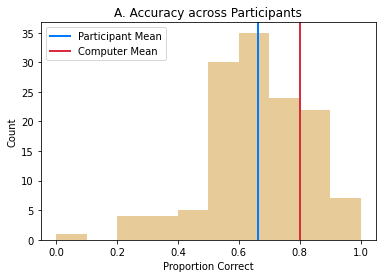

In [48]:
aa = list(sample1.groupby("prolific_pid").human_correct_guess.mean())
fig, ax = plt.subplots()
ax.hist([i for i in aa], bins=10, color=palette3, alpha=.8)
ax.axvline(x=sample1.human_correct_guess.mean(), ymin=0.0, ymax=20.0, color=palette1, linewidth=2,
          label="Participant Mean")
ax.axvline(x=sample1.groupby("video").computer_correct_guess.mean().mean(), ymin=0, ymax=20, color=palette5, linewidth=2,
          label="Computer Mean")
plt.legend()
plt.xlabel("Proportion Correct")
plt.ylabel("Count")
plt.title("A. Accuracy across Participants")
plt.savefig("Figure1_a.png",dpi=300)
plt.show()

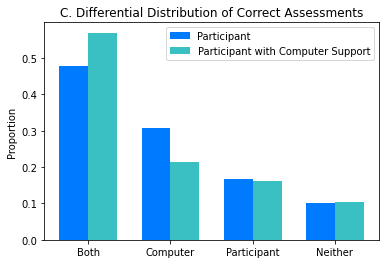

In [49]:
df2["x1"] = (df2.computer_correct_guess==1) & (df2.human_correct_guess==1)
df2["x2"] = (df2.computer_correct_guess==1) & (df2.human_correct_guess==0)
df2["x3"] = (df2.computer_correct_guess==0) & (df2.human_correct_guess==1)
df2["x4"] = (df2.computer_correct_guess==0) & (df2.human_correct_guess==0)
er1 = list(df2[(df2.guess_round==1) ].groupby("prolific_pid")[["x1","x2","x3","x4"]].sum().mean()/20)
er2 = list(df2[(df2.guess_round==2) ].groupby("prolific_pid")[["x1","x2","x3","x4"]].sum().mean()/20)
ind = np.arange(4) 
width = 0.35       
plt.bar(ind, er1, width, label='Participant', color=palette1)
plt.bar(ind + width, er2, width,
    label='Participant with Computer Support', color=palette2)
plt.ylabel('Proportion')
plt.title('C. Differential Distribution of Correct Assessments')

plt.xticks(ind + width / 2, ('Both',
                             'Computer', 
                             'Participant',
                             'Neither'
                            ))
plt.legend(loc='best')
plt.savefig("Figure1_c.png",dpi=300)
plt.show()

[0.   0.   0.   0.   0.   0.04 0.04 0.24 0.36 0.36 1.  ]


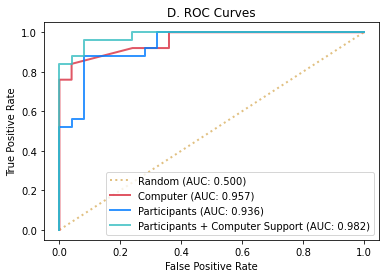

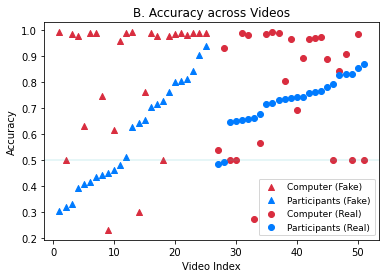

In [50]:
def video(df2, attention="check"):
    if attention=="check":
        df2 = df2[df2.pass_check_binary==1]
        g1 = pd.DataFrame(df2[(df2.guess_round==1) & (df2.assignment=="control")].groupby("video")['score','human_correct_guess',"guess_int",'fake',"p"].mean()).reset_index()
        g2 = pd.DataFrame(df2[(df2.guess_round==2) & (df2.assignment=="control")].groupby("video")["score",'human_correct_guess','guess_int'].mean()).reset_index()
    else:
        g1 = pd.DataFrame(df2[(df2.guess_round==1) & (df2.assignment=="control") ].groupby("video")['score','human_correct_guess',"guess_int",'fake',"p"].mean()).reset_index()
        g2 = pd.DataFrame(df2[(df2.guess_round==2) & (df2.assignment=="control") ].groupby("video")["score",'human_correct_guess','guess_int'].mean()).reset_index()
    g1.columns = ["video",'g1_score',"g1_accuracy","g1_confidence","fake", "c_prediction"]
    g2.columns = ["video","g2_score","g2_accuracy", "g2_confidence"]
    g = pd.merge(g1,g2,on="video").sort_values("g1_confidence")
    g = g[["video","fake", "c_prediction","g1_score","g1_confidence","g2_score","g2_accuracy","g1_accuracy","g2_confidence"]]
    g["c_score"] = g["c_prediction"]
    g.loc[(g.fake == 0),'c_score']=1-g.c_score
    g["ggg1_accuracy"] = g["g1_accuracy"]
    g.loc[(g.fake == 0),'ggg1_accuracy']=1-g.g1_accuracy
    video_all = g[(g.video!="v2attentioncheck.mp4")]
    video_dfdc = g[(g.video!="Putin_10s_b.mp4") & (g.video!="Putin_10s_a.mp4") & (g.video!="Kim_10s_b.mp4") & (g.video!="Kim_10s_a.mp4") &  (g.video!="v2attentioncheck.mp4")]
    
    c_fpr, c_tpr, thresholds = roc_curve(video_dfdc.fake, video_dfdc.c_prediction)
    c_auc = roc_auc_score(video_dfdc.fake, video_dfdc.c_prediction)
    h_fpr, h_tpr, thresholds = roc_curve(video_dfdc.fake, 100*video_dfdc.g1_confidence)
    h_auc = roc_auc_score(video_dfdc.fake, video_dfdc.g1_confidence)
    hc_fpr, hc_tpr, thresholds = roc_curve(video_dfdc.fake, video_dfdc.g2_confidence)
    hc_auc = roc_auc_score(video_dfdc.fake, video_dfdc.g2_confidence)
    print(c_fpr)
#     plt.plot([0,.1,.2,.5,.8,1], [0,.1,.2,.5,.8,1], label='Random (AUC: {:0.2f})'.format(.5), color=palette3, alpha=1, linestyle="dotted")
#     plt.plot(c_fpr, c_tpr, label='Computer (AUC: {:0.2f})'.format(c_auc), color=palette5, alpha=.8)
#     plt.plot(h_fpr, h_tpr, label='Human (AUC: {:0.2f})'.format(h_auc), color=palette1, alpha=.8)
# #     plt.plot(hc_fpr, hc_tpr, label='Human + Computer (AUC: {:0.2f})'.format(hc_auc), color=palette2, alpha=.8)
#     plt.legend()
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title ("ROC Curve")
#     plt.savefig("roc_a_{}_{}_{}.png".format(pp, n, attention),dpi=300)
#     plt.show()
    
    plt.plot([0,.1,.2,.5,.8,1], [0,.1,.2,.5,.8,1], label='Random (AUC: {:0.3f})'.format(.5), color=palette3, alpha=1, linestyle="dotted", linewidth=2)
    plt.plot(c_fpr, c_tpr, label='Computer (AUC: {:0.3f})'.format(c_auc), color=palette5, alpha=.8, linewidth=2)
    plt.plot(h_fpr, h_tpr, label='Participants (AUC: {:0.3f})'.format(h_auc), color=palette1, alpha=.8, linewidth=2)
    plt.plot(hc_fpr, hc_tpr, label='Participants + Computer Support (AUC: {:0.3f})'.format(hc_auc), color=palette2, alpha=.8, linewidth=2)
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title ("D. ROC Curves")
    plt.savefig("Figure1_d.png",dpi=300)
    plt.show()


    g["c_rank"]=g.c_score.rank(method="first")
    g["h_rank"]=g.g1_score.rank(method="first")
    g["ha_rank"]=g.g1_accuracy.rank(method="first")
    g = video_dfdc
    fig, ax1 = plt.subplots()
    g["c_rank"]=g.c_score.rank(method="first")
    g["h_rank"]=g.g1_score.rank(method="first")
    g["ha_rank"]=g.g1_accuracy.rank(method="first")
    gfrank = pd.DataFrame(g.groupby("fake").g1_score.rank())
    g = pd.merge(g,gfrank,left_index=True, right_index=True)
    g.loc[(g.fake == 0),'g1_score_y']=26+g.g1_score_y
    plt.title("B. Accuracy across Videos")
    plt.ylabel('Accuracy')
    plt.xlabel('Video Index')
    ax1.scatter(g[g.fake==1].g1_score_y, g[g.fake==1].c_score, label="Computer (Fake)", color=palette5, marker="^")
    ax1.scatter(g[g.fake==1].g1_score_y, g[g.fake==1].g1_score_x, label="Participants (Fake)", color=palette1, marker="^")
    ax1.scatter(g[g.fake==0 & (g.video.str.contains("10s")==False)].g1_score_y, g[g.fake==0].c_score, label="Computer (Real)", color=palette5)
    ax1.scatter(g[g.fake==0].g1_score_y, g[g.fake==0].g1_score_x, label="Participants (Real)", color=palette1)
    ax1.axhline(y=0.5, xmin=0.0, xmax=1.0, color=palette2,linewidth=.25)
    plt.legend(prop={'size': 9})
    plt.savefig("Figure1_b.png",dpi=300)
    plt.show()
    return video_dfdc, h_fpr, h_tpr, thresholds
g, fpr, tpr, thresh = video(df2, "check")

Index(['h_score'], dtype='object')


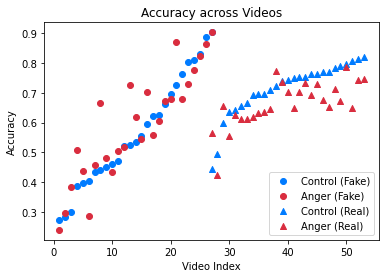

In [51]:
def video2(df2, s, rounder=1):
    df2 = df2[(df2.pass_check_binary==1) & (df2.video!="v2attentioncheck.mp4")]
    if s == "assignment":
        g = pd.DataFrame(df2[(df2.guess_round==rounder)].groupby(["video","assignment"])['score','fake',"p"].mean()).reset_index()
    else:
        g = pd.DataFrame(df2[(df2.guess_round==rounder)].groupby(["video","treatment_x"])['score','fake',"p"].mean()).reset_index()
    g.columns = ['video', 'assignment', 'h_score', 'fake', 'c_score']
    g.loc[(g.fake == 0),'c_score']=1-g.c_score    
    gfrank=pd.DataFrame(g[g.assignment=="control"].groupby("fake").h_score.rank(method="first"))
    print(gfrank.columns)
    gfrank.columns = ["ranker"]
    g0 = pd.merge(g,gfrank,left_index=True, right_index=True)
    g0=g0[["video","ranker"]]
    g = pd.merge(g,g0,on="video")
    g.loc[(g.fake == 0),'ranker']=26+g.ranker
    return g
g = video2(df2, "emotion", 1)
plt.scatter(g[(g.assignment=="control") & (g.fake==1)].ranker,g[(g.assignment=="control") & (g.fake==1)].h_score, color=palette1, label="Control (Fake)")
plt.scatter(g[(g.assignment=="anger") & (g.fake==1)].ranker,g[(g.assignment=="anger") & (g.fake==1)].h_score, color=palette5, label="Anger (Fake)")
plt.scatter(g[(g.assignment=="control") & (g.fake==0)].ranker,g[(g.assignment=="control") & (g.fake==0)].h_score, color=palette1, marker="^", label="Control (Real)")
plt.scatter(g[(g.assignment=="anger") & (g.fake==0)].ranker,g[(g.assignment=="anger") & (g.fake==0)].h_score, color=palette5, marker="^", label="Anger (Real)")
plt.ylabel('Accuracy')
plt.xlabel('Video Index')
plt.legend(prop={'size': 10}, loc="lower right")
plt.title("Accuracy across Videos")
plt.savefig("Anger.jpg",dpi=300)


We do not find any evidence that participants’ overall accuracy changes as participants view more videos. However, wefind that for every additional video seen non-recruited participants increase their likelihood that a video is a deepfake by 0.2%,which leads to performing 2% worse if the 10thvideo is real and performing 2% better if the 10thvideo is a deepfake.Non-recruited Participants spend a median of 20 seconds (interquartile range is 15 to 29 seconds) viewing each video anda median 2 seconds (interquartile range is 1 to 5 seconds) adjusting their confirmation. We find that for every ten additionalseconds participants take on the margin, participants’ accuracy decreases by 2 percentage points (p<.01, unregistered).

# Treatment Effects

In [52]:
print(df2[df2.guess_round==1].assignment.value_counts())
print(df2[df2.guess_round==1].treatment_x.value_counts())

control            3044
eye_occlusion      1064
inversion          1012
misalignment        966
attention_check     304
Name: assignment, dtype: int64
control    3489
anger      2901
Name: treatment_x, dtype: int64


In [53]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
fixed_effects = pd.get_dummies(df2.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c]):
    if index<3:
        columns = ["misalignment","eye_occlusion","inversion", "anger"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    else:
        columns = ["misalignment","eye_occlusion","inversion"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique()]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50)]
fiftyfifty_guesses = [sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50)]
    
    
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet"], [3,3])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", "anger"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'anger': "Anger"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)

HTML(stargazer.render_latex())

In [57]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
fixed_effects = pd.get_dummies(df2.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c]):
    if index<3:
        columns = ["misalignment","eye_occlusion","inversion", "anger"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['human_correct_guess'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    else:
        columns = ["misalignment","eye_occlusion","inversion"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['human_correct_guess'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique()]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50)]
fiftyfifty_guesses = [sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50)]
    
    
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet"], [3,3])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", "anger"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'anger': "Anger"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)

HTML(stargazer.render_html())

In [56]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)

exp2a["extreme"] = exp2a["guess_int"]
exp2a.loc[(exp2a["guess_int"]<50),"extreme"]=100-exp2a["guess_int"]

exp2b["extreme"] = exp2b["guess_int"]
exp2b.loc[(exp2b["guess_int"]<50),"extreme"]=100-exp2b["guess_int"]


fixed_effects = pd.get_dummies(df2.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c]):
    if index<3:
        columns = ["misalignment","eye_occlusion","inversion", "anger"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['extreme'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    else:
        columns = ["misalignment","eye_occlusion","inversion"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['extreme'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique()]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50)]
fiftyfifty_guesses = [sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50)]
    
    
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet"], [3,3])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", "anger"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'anger': "Anger"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)

HTML(stargazer.render_html())

In [59]:
x[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     human_correct_guess   R-squared:                       0.154
Model:                             OLS   Adj. R-squared:                  0.153
Method:                  Least Squares   F-statistic:                     2140.
Date:                 Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                         18:18:32   Log-Likelihood:                -34700.
No. Observations:                58441   AIC:                         6.951e+04
Df Residuals:                    58384   BIC:                         7.003e+04
Df Model:                           56                                         
Covariance Type:               cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6692      0.003    240.061      0.000       0.664       0.675
misalignment       -0.0751      0.005    -14.028      0.000      -0.086      -0.065
eye_occlusion      -0.0438      0.005     -8.706      0.000      -0.054      -0.034
inversion          -0.0646      0.005    -12.417      0.000      -0.075      -0.054
4110.mp4           -0.3621      0.013    -26.833      0.000      -0.389      -0.336
4121.mp4            0.3212      0.006     51.146      0.000       0.309       0.334
4122.mp4            0.0296      0.013      2.214      0.027       0.003       0.056
4135.mp4            0.1570      0.012     13.011      0.000       0.133       0.181
4250.mp4            0.2049      0.011     18.811      0.000       0.184       0.226
4261.mp4            0.0405      0.014      2.891      0.004       0.013       0.068
4545.mp4            0.0225      0.015      1.530      0.126      -0.006       0.051
4555.mp4           -0.4403      0.012    -35.612      0.000      -0.464      -0.416
4704.mp4            0.0802      0.013      6.022      0.000       0.054       0.106
4712.mp4            0.1111      0.013      8.640      0.000       0.086       0.136
4742.mp4            0.3105      0.007     46.098      0.000       0.297       0.324
4757.mp4           -0.1839      0.016    -11.631      0.000      -0.215      -0.153
5142.mp4           -0.2776      0.014    -19.361      0.000      -0.306      -0.249
5201.mp4            0.1632      0.012     13.754      0.000       0.140       0.186
5319.mp4           -0.2103      0.014    -14.601      0.000      -0.239      -0.182
5370.mp4            0.1280      0.013     10.003      0.000       0.103       0.153
5471.mp4           -0.2260      0.015    -15.139      0.000      -0.255      -0.197
5534.mp4           -0.1070      0.015     -7.297      0.000      -0.136      -0.078
5785.mp4           -0.1710      0.015    -11.360      0.000      -0.200      -0.141
5843.mp4           -0.4013      0.013    -31.080      0.000      -0.427      -0.376
5844.mp4           -0.0333      0.015     -2.215      0.027      -0.063      -0.004
5908.mp4            0.0621      0.014      4.365      0.000       0.034       0.090
6153.mp4            0.2026      0.011     18.989      0.000       0.182       0.224
6189.mp4            0.0086      0.014      0.601      0.548      -0.020       0.037
6216.mp4            0.1278      0.013     10.196      0.000       0.103       0.152
6251.mp4            0.0115      0.014      0.812      0.417      -0.016       0.039
6537.mp4           -0.2673      0.014    -18.529      0.000      -0.296      -0.239
6561.mp4           -0.0150      0.014     -1.043      0.297      -0.043       0.013
6564.mp4            0.0695      0.013      5.231      0.000       0.043       0.096
6575.mp4            0.2853      0.008     35.921

In [24]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
fixed_effects = pd.get_dummies(df2.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c]):
    if index<3:
        columns = ["seen"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    else:
        columns = ["seen"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique()]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50)]
fiftyfifty_guesses = [sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50)]
    
    
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet"], [3,3])
stargazer.covariate_order(['const', "seen"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'seen':"Seen"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)

HTML(stargazer.render_html())

In [25]:
def get_delay(df2, kind):
    if kind == "prolific":
        df3=df2.sort_values(["prolific_pid","time_created_guess"], ascending=True)
        df3['t2']=pd.to_datetime(df3.groupby(['prolific_pid'])['time_created_guess'].shift(1))
        df3['time_created']=pd.to_datetime(df3['time_created_guess'])
    else:
        df3=df2.sort_values(["user_id","time_created"], ascending=True)
        df3['t2']=pd.to_datetime(df3.groupby(['user_id'])['time_created'].shift(1))
        df3['time_created']=pd.to_datetime(df3['time_created'])
    # df=df[df.t2.notnull()]
    df3["delta"]=df3.time_created-df3.t2
    df3.delta = df3.delta.dt.seconds
    print(df3[(df3.guess_round==1) & (df2.seen<=20)].delta.describe())
    print(df3[(df3.guess_round==2) & (df2.seen<=20)].delta.describe())

    df3 = df3[df3.delta<120]
    return df3


In [26]:
exp2a = get_delay(pd.read_csv(experiment1_prolific_csv),"prolific")
exp2b = get_delay(pd.read_csv(experiment1_internet_csv),"internet")

fixed_effects = pd.get_dummies(exp2a.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c]):
    if index<3:
        columns = ["delta"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    else:
        columns = ["delta"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique()]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50)]
fiftyfifty_guesses = [sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50)]
    
    
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet"], [3,3])
stargazer.covariate_order(['const', "delta"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'delta':"Delay"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)

HTML(stargazer.render_html())

count     6086.000000
mean        33.687644
std        193.247482
min          0.000000
25%         17.000000
50%         22.000000
75%         31.000000
max      11705.000000
Name: delta, dtype: float64
count    6378.000000
mean        4.745532
std         6.127315
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        99.000000
Name: delta, dtype: float64
count    52833.000000
mean        69.652149
std       1367.584197
min          0.000000
25%         15.000000
50%         21.000000
75%         30.000000
max      84904.000000
Name: delta, dtype: float64
count    61553.000000
mean         5.020032
std        105.860920
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      17728.000000
Name: delta, dtype: float64


In [27]:
df2 = df2[df2.seen>0]
a1 = df2[df2.guess_round==1]
b1 = df2[(df2.fake==0) & (df2.guess_round==1)]
c1 = df2[(df2.fake==1) & (df2.guess_round==1)]
a2 = df2[(df2.guess_round==1) & (df2.pass_check_binary==1)]
b2 = df2[(df2.fake==0) & (df2.guess_round==1) & (df2.pass_check_binary==1)]
c2 = df2[(df2.fake==1) & (df2.guess_round==1) & (df2.pass_check_binary==1)]
a3 = df2[(df2.guess_round==2) & (df2.pass_check_binary==1)]
b3 = df2[(df2.fake==0) & (df2.guess_round==2) & (df2.pass_check_binary==1)]
c3 = df2[(df2.fake==1) & (df2.guess_round==2) & (df2.pass_check_binary==1)]
x = []
columns = ["misalignment","eye_occlusion","inversion","anger"]
for i in fe:
    columns.append(i)
for i in [a1, b1,c1,a2,b2,c2,a3,b3,c3]:
    res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(
                    cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    x.append(res)
    
stargazer = Stargazer([x[0],x[1],x[2]])
stargazer.title("Round 1 (All Respondents)")
stargazer.custom_columns(['All', "Real", "DeepFake"], [1,1,1])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", 'anger'])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment'})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', [a1.prolific_pid.nunique(),a1.prolific_pid.nunique(),a1.prolific_pid.nunique()])
stargazer.add_line('Number of Guesses (Real)', [sum(a1.guess_int<50), sum(b1.guess_int<50), sum(c1.guess_int<50)])
stargazer.add_line('Number of Guesses (Deepfake)', [sum(a1.guess_int>50), sum(b1.guess_int>50), sum(c1.guess_int>50)])
stargazer.add_line('Number of Guesses (Not sure)', [sum(a1.guess_int==50), sum(b1.guess_int==50), sum(c1.guess_int==50)])

HTML(stargazer.render_html())

In [28]:
stargazer = Stargazer([x[3],x[4],x[5]])
stargazer.title("Round 1 (Pass Attention Check)")
stargazer.custom_columns(['All', "Real", "DeepFake"], [1,1,1])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", 'anger',])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment'})
stargazer.significant_digits(3)
stargazer.add_line('Number of Participants', [a2.prolific_pid.nunique(),b2.prolific_pid.nunique(),c2.prolific_pid.nunique()])
stargazer.add_line('Number of Guesses (Real)', [sum(a1.guess_int<50), sum(b1.guess_int<50), sum(c1.guess_int<50)])
stargazer.add_line('Number of Guesses (Deepfake)', [sum(a1.guess_int>50), sum(b1.guess_int>50), sum(c1.guess_int>50)])
stargazer.add_line('Number of Guesses (Not sure)', [sum(a1.guess_int==50), sum(b1.guess_int==50), sum(c1.guess_int==50)])
stargazer.show_degrees_of_freedom(False)
HTML(stargazer.render_html
     ())

In [29]:
stargazer = Stargazer([x[6],x[7],x[8]])
stargazer.title("Round 2 (Pass Attention Check)")
stargazer.custom_columns(['All', "Real", "DeepFake"], [1,1,1])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", 'anger'])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment'})
stargazer.significant_digits(3)
stargazer.add_line('Number of Participants', [a3.prolific_pid.nunique(),b3.prolific_pid.nunique(),c3.prolific_pid.nunique()])

stargazer.show_degrees_of_freedom(False)
HTML(stargazer.render_html())

In [30]:
video_scores = pd.DataFrame(df2[["video","score","c_score", "fake"]][(df2.guess_round==2) & (df2.treatment_x=="control") &
     ((df2.assignment=="control") | (df2.assignment=="attention_check"))].groupby("video").mean()).reset_index().sort_values("score")
video_scores.columns = ["video","crowd_consensus_prolific","computer_vision","fake"]
video_scores.crowd_consensus_prolific = video_scores.crowd_consensus_prolific.round(2)
video_scores.computer_vision = video_scores.computer_vision.round(2)

video_scores_x = pd.DataFrame(df2_x[["video","score"]][(df2_x.guess_round==2) &
     ((df2_x.assignment=="control") | (df2_x.assignment=="attention_check"))].groupby("video").mean()).reset_index().sort_values("score")
video_scores_x.columns = ["video","crowd_consensus_internet"]
video_scores_x.crowd_consensus_internet = video_scores_x.crowd_consensus_internet.round(2)

video_scores_m = pd.merge(video_scores, video_scores_x,on="video")
video_scores_m.to_csv("replication/computer_vision_human_comparison.csv", index=False)

In [31]:
computer = pd.read_csv(model_performance_csv)
computer = computer[computer.video.str.contains("10s")==False]
print(computer.control_score.mean(),computer.inversion_score.mean(),stats.ttest_ind(computer.control_score,computer.inversion_score)[1])
print(computer.control_score.mean(),computer.misalignment_score.mean(),stats.ttest_ind(computer.control_score,computer.misalignment_score)[1])
print(computer.control_score.mean(),computer.eye_occlusion_score.mean(),stats.ttest_ind(computer.control_score,computer.eye_occlusion_score)[1])

0.8134596252441406 0.69278076171875 0.0056485407505060346
0.8134596252441406 0.8241441345214844 0.8008442537894884
0.8134596252441406 0.8105055236816406 0.9483905241331909
